# SDC-System-Integration Generative Adversarial Network (GAN) Classifier
## Refined for SITE.

In [1]:
# import some useful modules

%matplotlib inline

import pickle as pkl
import time

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2

from os.path import isfile, isdir
from tqdm import tqdm

from IPython.display import display

## Import our data set (Only Rosbag)

In [2]:
incsv1 = '../../test_images/bad_loop_with_traffic_light.csv'
sample1 = pd.read_csv(incsv1, header=0, sep=',')
sample1 = sample1.drop('x', axis=1)
sample1 = sample1.drop('y', axis=1)
sample1 = sample1.drop('z', axis=1)
sample1 = sample1.drop('ax', axis=1)
sample1 = sample1.drop('ay', axis=1)
sample1 = sample1.drop('az', axis=1)
sample1 = sample1.drop('aw', axis=1)
samples = sample1
samples.columns = ['X','y']

samples.head()

X  y
0  'test_images/loop_with_traffic_light_0322.jpg'  0
1  'test_images/loop_with_traffic_light_0324.jpg'  0
2  'test_images/loop_with_traffic_light_0325.jpg'  0
3  'test_images/loop_with_traffic_light_0327.jpg'  0
4  'test_images/loop_with_traffic_light_0328.jpg'  0

In [3]:
samples.describe()

y
count  186.000000
mean     2.397849
std      1.525564
min      0.000000
25%      2.000000
50%      2.000000
75%      4.000000
max      4.000000

In [4]:
# number of samples
n_samples = len(samples.index)
# calculate the number of RED light: 0
n_red = len(samples[(samples.y==0)])
# calculate the number of YELLOW light: 1
n_yellow = len(samples[(samples.y==1)])
# calculate the number of GREEN light: 2
n_green = len(samples[(samples.y==2)])
# calculate the number of UNKNOWN: 4
n_unknown = len(samples[(samples.y==4)])

# Print the results
print "Total number of samples: {}".format(n_samples)
print "Number of samples red: {}".format(n_red)
print "Number of samples green: {}".format(n_green)
print "Number of samples yellow: {}".format(n_yellow)
print "Number of samples unknown: {}".format(n_unknown)

Total number of samples: 186
Number of samples red: 39
Number of samples green: 71
Number of samples yellow: 0
Number of samples unknown: 76


In [5]:
# Shuffle Pandas data frame
import sklearn.utils
samples = sklearn.utils.shuffle(samples)

splitnum = int(n_samples*0.8)
trainset = samples.iloc[:splitnum]
testset  = samples.iloc[splitnum:]

# Show the results of the split

print trainset.head()
# number of samples
n_trainsamples = len(trainset.index)
# calculate the number of RED light: 0
n_trainred = len(trainset[(trainset.y==0)])
# calculate the number of YELLOW light: 1
n_trainyellow = len(trainset[(trainset.y==1)])
# calculate the number of GREEN light: 2
n_traingreen = len(trainset[(trainset.y==2)])
# calculate the number of UNKNOWN: 4
n_trainunknown = len(trainset[(trainset.y==4)])

# Print the results
print ""
print "Training set has {} samples.".format(trainset.shape[0])
print "Number of samples red: {}".format(n_trainred)
print "Number of samples green: {}".format(n_traingreen)
print "Number of samples yellow: {}".format(n_trainyellow)
print "Number of samples unknown: {}".format(n_trainunknown)
print ""

print testset.head()
# number of samples
n_testsamples = len(testset.index)
# calculate the number of RED light: 0
n_testred = len(testset[(testset.y==0)])
# calculate the number of YELLOW light: 1
n_testyellow = len(testset[(testset.y==1)])
# calculate the number of GREEN light: 2
n_testgreen = len(testset[(testset.y==2)])
# calculate the number of UNKNOWN: 4
n_testunknown = len(testset[(testset.y==4)])

# Print the results
print ""
print "Testing set has {} samples.".format(testset.shape[0])
print "Number of samples red: {}".format(n_testred)
print "Number of samples green: {}".format(n_testgreen)
print "Number of samples yellow: {}".format(n_testyellow)
print "Number of samples unknown: {}".format(n_testunknown)

                                                  X  y
78   'test_images/loop_with_traffic_light_0712.jpg'  2
62   'test_images/loop_with_traffic_light_0421.jpg'  4
91   'test_images/loop_with_traffic_light_0732.jpg'  2
177  'test_images/loop_with_traffic_light_1136.jpg'  4
100  'test_images/loop_with_traffic_light_0746.jpg'  4

Training set has 148 samples.
Number of samples red: 29
Number of samples green: 58
Number of samples yellow: 0
Number of samples unknown: 61

                                                  X  y
184  'test_images/loop_with_traffic_light_1148.jpg'  4
71   'test_images/loop_with_traffic_light_0701.jpg'  2
123  'test_images/loop_with_traffic_light_1052.jpg'  2
131  'test_images/loop_with_traffic_light_1064.jpg'  2
156  'test_images/loop_with_traffic_light_1104.jpg'  4

Testing set has 38 samples.
Number of samples red: 10
Number of samples green: 13
Number of samples yellow: 0
Number of samples unknown: 15


In [6]:
def getImage(imagefile):
    imagepath = '../../'+imagefile.replace("'", "")
    image = cv2.imread(imagepath, 1)
    row, col, ch = image.shape
    if row != 600 or col != 800:
        image = cv2.resize(image, (600, 800), interpolation=cv2.INTER_AREA)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

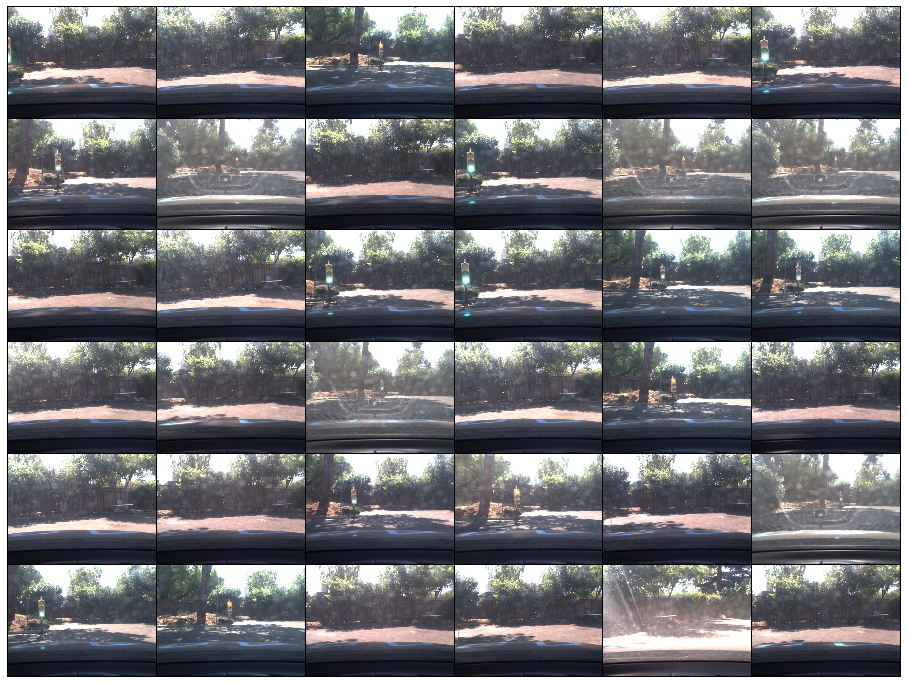

In [7]:
idx = np.random.randint(0, len(trainset['X']), size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(16,12),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(getImage(trainset['X'].iloc[ii]), aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

## Preparing the data

In [8]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [21]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:split_idx], test['X'][split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        self.label_mask = np.ones(len(self.train_y)+128)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size, which_set="train"):
        x_name = which_set + "_x"
        y_name = which_set + "_y"
        
        num_examples = len(getattr(dataset, y_name))
        if self.shuffle:
            idx = np.arange(num_examples)
            np.random.shuffle(idx)
            setattr(dataset, x_name, getattr(dataset, x_name)[idx])
            setattr(dataset, y_name, getattr(dataset, y_name)[idx])
            if which_set == "train":
                dataset.label_mask = dataset.label_mask[idx]
        
        dataset_x = getattr(dataset, x_name)
        dataset_y = getattr(dataset, y_name)
        for ii in range(0, num_examples, batch_size):
            x = []
            y = []
            for j in range(batch_size):
                x.append(self.scaler(getImage(dataset_x.iloc[(ii+j)%num_examples])))
                y.append(dataset_y.iloc[(ii+j)%num_examples])
            x = np.array(x).reshape(-1, 600, 800, 3)
            y = np.array(y).reshape(-1, 1)
            
            if which_set == "train":
                # When we use the data for training, we need to include
                # the label mask, so we can pretend we don't have access
                # to some of the labels, as an exercise of our semi-supervised
                # learning ability
                yield x, y, self.label_mask[ii:ii+batch_size]
            else:
                yield x, y

## The GAN model

In [10]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, real_dim[0], real_dim[1], real_dim[2]), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    y = tf.placeholder(tf.int32, (None), name='y')
    label_mask = tf.placeholder(tf.int32, (None), name='label_mask')
    
    return inputs_real, inputs_z, y, label_mask

In [11]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True, size_mult=128):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * size_mult * 4)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, size_mult * 4))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, size_mult * 2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, size_mult, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

In [12]:
def discriminator(x, reuse=False, alpha=0.2, drop_rate=0., num_classes=10, size_mult=64):
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.dropout(x, rate=drop_rate/2.5)
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, size_mult, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        relu1 = tf.layers.dropout(relu1, rate=drop_rate)
        
        x2 = tf.layers.conv2d(relu1, size_mult, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        
        
        x3 = tf.layers.conv2d(relu2, size_mult, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        relu3 = tf.layers.dropout(relu3, rate=drop_rate)
        
        x4 = tf.layers.conv2d(relu3, 2 * size_mult, 3, strides=1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        
        x5 = tf.layers.conv2d(relu4, 2 * size_mult, 3, strides=1, padding='same')
        bn5 = tf.layers.batch_normalization(x5, training=True)
        relu5 = tf.maximum(alpha * bn5, bn5)
        
        x6 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=2, padding='same')
        bn6 = tf.layers.batch_normalization(x6, training=True)
        relu6 = tf.maximum(alpha * bn6, bn6)
        relu6 = tf.layers.dropout(relu6, rate=drop_rate)
        
        x7 = tf.layers.conv2d(relu5, 2 * size_mult, 3, strides=1, padding='valid')
        # Don't use bn on this layer, because bn would set the mean of each feature
        # to the bn mu parameter.
        # This layer is used for the feature matching loss, which only works if
        # the means can be different when the discriminator is run on the data than
        # when the discriminator is run on the generator samples.
        relu7 = tf.maximum(alpha * x7, x7)
        
        # Flatten it by global average pooling
        features = tf.reduce_mean(relu7, (1, 2))
        
        # Set class_logits to be the inputs to a softmax distribution over the different classes
        class_logits = tf.layers.dense(features, num_classes + extra_class)
        
        
        # Set gan_logits such that P(input is real | input) = sigmoid(gan_logits).
        # Keep in mind that class_logits gives you the probability distribution over all the real
        # classes and the fake class. You need to work out how to transform this multiclass softmax
        # distribution into a binary real-vs-fake decision that can be described with a sigmoid.
        # Numerical stability is very important.
        # You'll probably need to use this numerical stability trick:
        # log sum_i exp a_i = m + log sum_i exp(a_i - m).
        # This is numerically stable when m = max_i a_i.
        # (It helps to think about what goes wrong when...
        #   1. One value of a_i is very large
        #   2. All the values of a_i are very negative
        # This trick and this value of m fix both those cases, but the naive implementation and
        # other values of m encounter various problems)
        
        if extra_class:
            real_class_logits, fake_class_logits = tf.split(class_logits, [num_classes, 1], 1)
            assert fake_class_logits.get_shape()[1] == 1, fake_class_logits.get_shape()
            fake_class_logits = tf.squeeze(fake_class_logits)
        else:
            real_class_logits = class_logits
            fake_class_logits = 0.
        
        mx = tf.reduce_max(real_class_logits, 1, keep_dims=True)
        stable_real_class_logits = real_class_logits - mx

        gan_logits = tf.log(tf.reduce_sum(tf.exp(stable_real_class_logits), 1)) + tf.squeeze(mx) - fake_class_logits
        
        out = tf.nn.softmax(class_logits)
        
        return out, class_logits, gan_logits, features

In [13]:
def model_loss(input_real, input_z, output_dim, y, num_classes, label_mask, alpha=0.2, drop_rate=0.):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param output_dim: The number of channels in the output image
    :param y: Integer class labels
    :param num_classes: The number of classes
    :param alpha: The slope of the left half of leaky ReLU activation
    :param drop_rate: The probability of dropping a hidden unit
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    
    # These numbers multiply the size of each layer of the generator and the discriminator,
    # respectively. You can reduce them to run your code faster for debugging purposes.
    g_size_mult = 32
    d_size_mult = 64
    
    # Here we run the generator and the discriminator
    g_model = generator(input_z, output_dim, alpha=alpha, size_mult=g_size_mult)
    d_on_data = discriminator(input_real, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_real, class_logits_on_data, gan_logits_on_data, data_features = d_on_data
    d_on_samples = discriminator(g_model, reuse=True, alpha=alpha, drop_rate=drop_rate, size_mult=d_size_mult)
    d_model_fake, class_logits_on_samples, gan_logits_on_samples, sample_features = d_on_samples
    
    
    # Here we compute `d_loss`, the loss for the discriminator.
    # This should combine two different losses:
    #  1. The loss for the GAN problem, where we minimize the cross-entropy for the binary
    #     real-vs-fake classification problem.
    #  2. The loss for the SVHN digit classification problem, where we minimize the cross-entropy
    #     for the multi-class softmax. For this one we use the labels. Don't forget to ignore
    #     use `label_mask` to ignore the examples that we are pretending are unlabeled for the
    #     semi-supervised learning problem.
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_data,
                                                labels=tf.ones_like(gan_logits_on_data)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=gan_logits_on_samples,
                                                labels=tf.zeros_like(gan_logits_on_samples)))
    y = tf.squeeze(y)
    class_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=class_logits_on_data,
                                                                  labels=tf.one_hot(y, num_classes + extra_class,
                                                                                    dtype=tf.float32))
    class_cross_entropy = tf.squeeze(class_cross_entropy)
    label_mask = tf.squeeze(tf.to_float(label_mask))
    d_loss_class = tf.reduce_sum(label_mask * class_cross_entropy) / tf.maximum(1., tf.reduce_sum(label_mask))
    d_loss = d_loss_class + d_loss_real + d_loss_fake
    
    # Here we set `g_loss` to the "feature matching" loss invented by Tim Salimans at OpenAI.
    # This loss consists of minimizing the absolute difference between the expected features
    # on the data and the expected features on the generated samples.
    # This loss works better for semi-supervised learning than the tradition GAN losses.
    data_moments = tf.reduce_mean(data_features, axis=0)
    sample_moments = tf.reduce_mean(sample_features, axis=0)
    g_loss = tf.reduce_mean(tf.abs(data_moments - sample_moments))

    pred_class = tf.cast(tf.argmax(class_logits_on_data, 1), tf.int32, name="predict")
    eq = tf.equal(tf.squeeze(y), pred_class)
    correct = tf.reduce_sum(tf.to_float(eq))
    masked_correct = tf.reduce_sum(label_mask * tf.to_float(eq))
    
    return d_loss, g_loss, correct, masked_correct, g_model

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and biases to update. Get them separately for the discriminator and the generator
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    for t in t_vars:
        assert t in d_vars or t in g_vars

    # Minimize both players' costs simultaneously
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    shrink_lr = tf.assign(learning_rate, learning_rate * 0.9)
    
    return d_train_opt, g_train_opt, shrink_lr



In [15]:
class GAN:
    """
    A GAN model.
    :param real_size: The shape of the real data.
    :param z_size: The number of entries in the z code vector.
    :param learnin_rate: The learning rate to use for Adam.
    :param num_classes: The number of classes to recognize.
    :param alpha: The slope of the left half of the leaky ReLU activation
    :param beta1: The beta1 parameter for Adam.
    """
    def __init__(self, real_size, z_size, learning_rate, num_classes=10, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.learning_rate = tf.Variable(learning_rate, trainable=False)
        self.input_real, self.input_z, self.y, self.label_mask = model_inputs(real_size, z_size)
        self.drop_rate = tf.placeholder_with_default(.5, (), "drop_rate")
        
        loss_results = model_loss(self.input_real, self.input_z,
                                              real_size[2], self.y, num_classes, label_mask=self.label_mask,
                                                                          alpha=0.2,
                                                           drop_rate=self.drop_rate)
        self.d_loss, self.g_loss, self.correct, self.masked_correct, self.samples = loss_results
        
        self.d_opt, self.g_opt, self.shrink_lr = model_opt(self.d_loss, self.g_loss, self.learning_rate, beta1)


In [16]:
def view_samples(epoch, samples, nrows, ncols, figsize=(8,6)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img)
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [17]:
def train(net, dataset, epochs, batch_size, figsize=(8,6), load=False):
    
    saver = tf.train.Saver()
    sample_z = np.random.normal(0, 1, size=(50, z_size))
    
    samples, train_accuracies, test_accuracies = [], [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        if load:
            saver.restore(sess, './checkpoints/generator.ckpt')
            print "Model restored."

        for e in range(epochs):
            print "Epoch",e
            
            t1e = time.time()
            num_examples = 0
            num_correct = 0
            for x, y, label_mask in dataset.batches(batch_size):
                assert 'int' in str(y.dtype)
                steps += 1
                num_examples += label_mask.sum()

                # Sample random noise for G
                batch_z = np.random.normal(0, 1, size=(batch_size, z_size))

                # Run optimizers
                t1 = time.time()
                _, _, correct = sess.run([net.d_opt, net.g_opt, net.masked_correct],
                                         feed_dict={net.input_real: x, net.input_z: batch_z,
                                                    net.y : y, net.label_mask : label_mask})
                t2 = time.time()
                num_correct += correct

            sess.run([net.shrink_lr])
            
            
            train_accuracy = num_correct / float(num_examples)
            
            print "\t\tClassifier train accuracy: ", train_accuracy
            
            num_examples = 0
            num_correct = 0
            for x, y in dataset.batches(batch_size, which_set="test"):
                assert 'int' in str(y.dtype)
                num_examples += x.shape[0]

                correct, = sess.run([net.correct], feed_dict={net.input_real: x,
                                                   net.y : y,
                                                   net.drop_rate: 0.})
                num_correct += correct
            
            test_accuracy = num_correct / float(num_examples)
            print "\t\tClassifier test accuracy: ", test_accuracy
            print "\t\tStep time: ", t2 - t1
            t2e = time.time()
            print "\t\tEpoch time: ", t2e - t1e
            
            
            gen_samples = sess.run(
                                   net.samples,
                                   feed_dict={net.input_z: sample_z})
            samples.append(gen_samples)
            _ = view_samples(-1, samples, 5, 10, figsize=figsize)
            plt.show()
            
            
            # Save history of accuracies to view after training
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return train_accuracies, test_accuracies, samples

In [18]:
#!mkdir checkpoints

In [31]:
extra_class = 0
real_size = (600,800,3)
z_size = 100
learning_rate = 0.0001

net = GAN(real_size, z_size, learning_rate)


INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt
Model restored.
Epoch 0
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0745060443878
		Epoch time:  5.62581300735


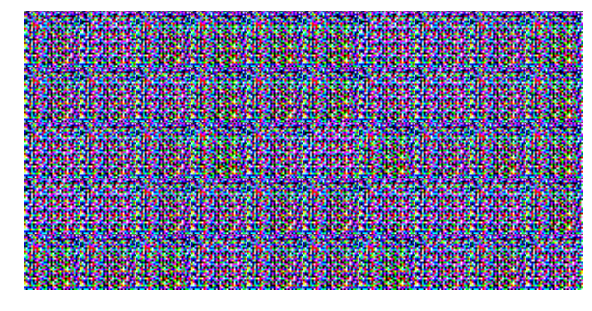

Epoch 1
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0809109210968
		Epoch time:  5.80956602097


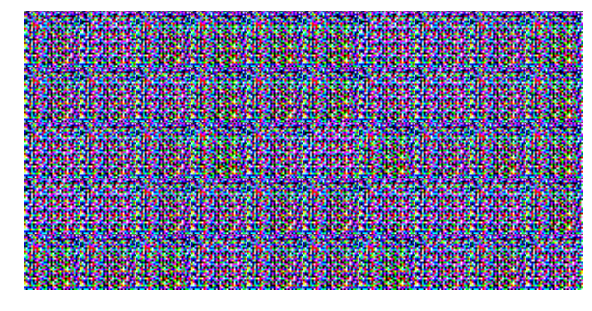

Epoch 2
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0751001834869
		Epoch time:  5.42276096344


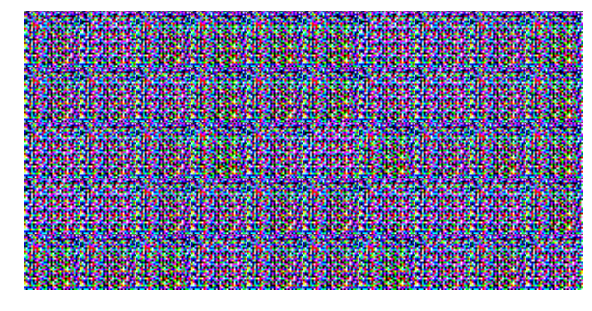

Epoch 3
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0759811401367
		Epoch time:  5.50448298454


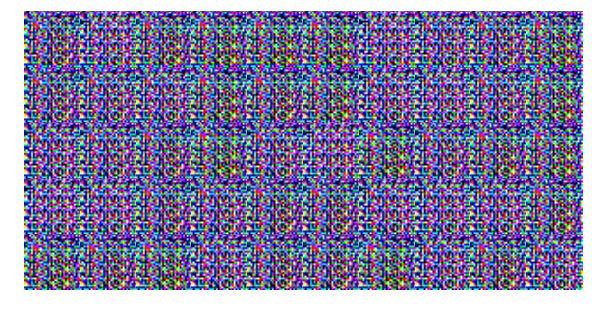

Epoch 4
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0779500007629
		Epoch time:  5.97212791443


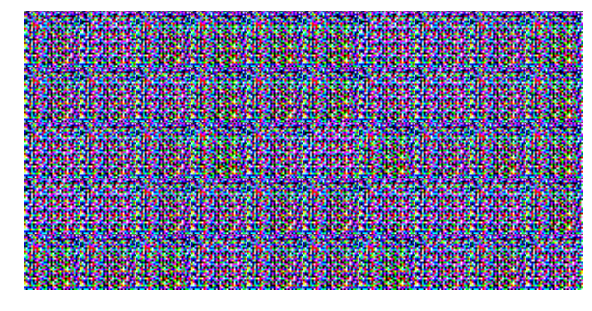

Epoch 5
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0768039226532
		Epoch time:  5.48273611069


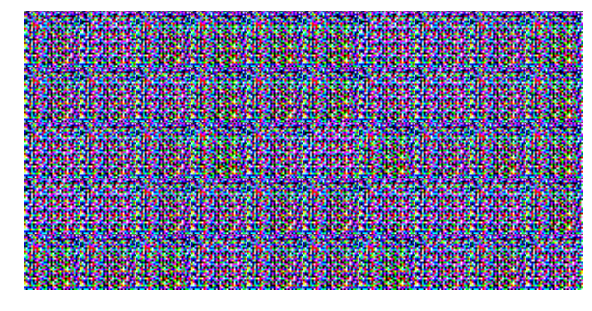

Epoch 6
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0732839107513
		Epoch time:  5.52382397652


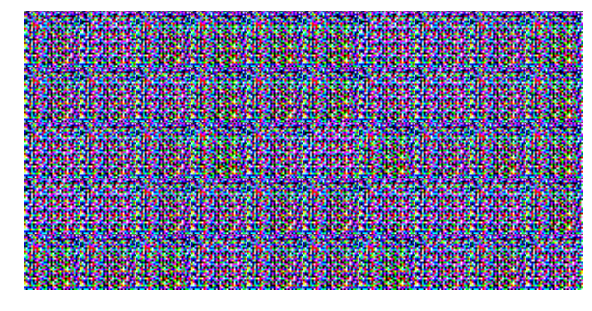

Epoch 7
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0791280269623
		Epoch time:  5.68384194374


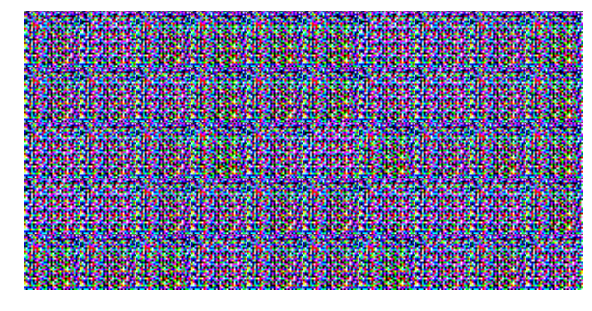

Epoch 8
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0767550468445
		Epoch time:  5.62748503685


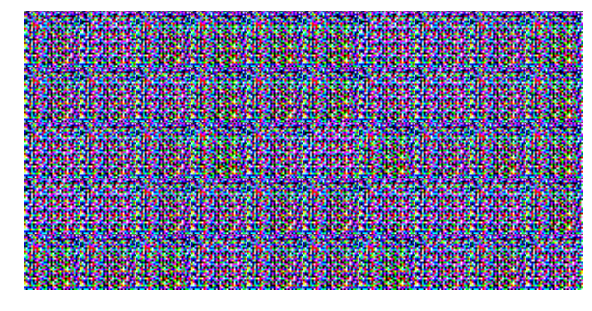

Epoch 9
		Classifier train accuracy:  0.873333333333
		Classifier test accuracy:  0.952380952381
		Step time:  0.0736260414124
		Epoch time:  5.43510389328


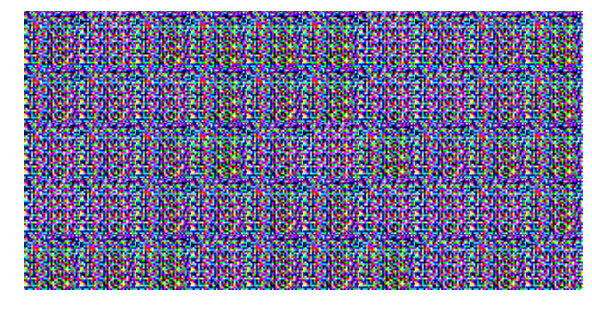

In [32]:
dataset = Dataset(trainset, testset)

batch_size = 3
epochs = 10
train_accuracies, test_accuracies, samples = train(net, dataset, epochs, batch_size, figsize=(10,5), load=True)

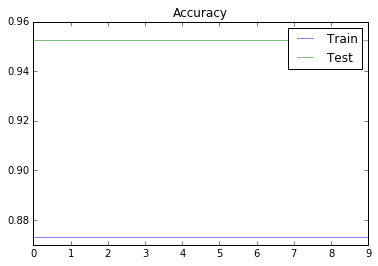

In [33]:
fig, ax = plt.subplots()
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy")
plt.legend()

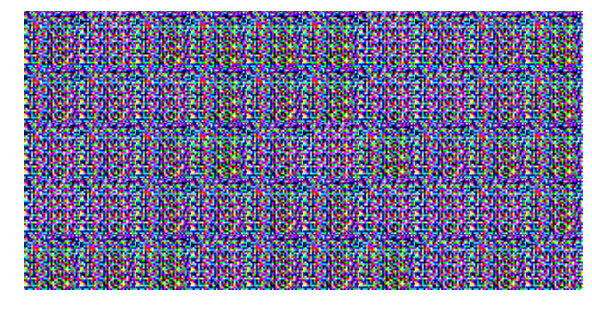

In [34]:
_ = view_samples(-1, samples, 5, 10, figsize=(10,5))

In [48]:
# prediction function
label = ['red', 'yellow', 'green', '', 'unknown']
import os
def prediction(image_file):
    
    # load color (BGR) image
    img = cv2.imread(image_file)

    # convert BGR image to RGB for plotting
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
    sess = tf.Session()
    saver = tf.train.import_meta_graph('./checkpoints/generator.ckpt.meta')
    saver.restore(sess,tf.train.latest_checkpoint('./checkpoints/'))
    graph = tf.get_default_graph()
    input_real = graph.get_tensor_by_name("input_real:0")
    drop_rate = graph.get_tensor_by_name("drop_rate:0")
    predict = graph.get_tensor_by_name("predict:0")

    predict = sess.run(predict, feed_dict = {
        input_real: scale(img.reshape(-1, 600, 800, 3)),
        drop_rate:0.})
        
    # display the image and prediction
    fg, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    ax1.text(.5, .5, 'Most Likely: %s'%(label[predict[0]]), fontsize=12, horizontalalignment='center', verticalalignment='center')
    ax1.set_axis_off()
    ax2.set_title('Prediction')
    ax2.imshow(img)
    plt.show()

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt


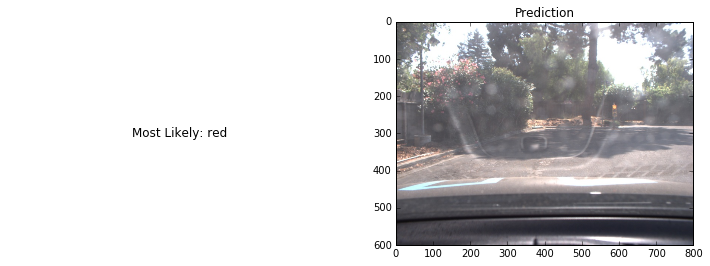

In [49]:
prediction('../../test_images/loop_with_traffic_light_0292.jpg')

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt


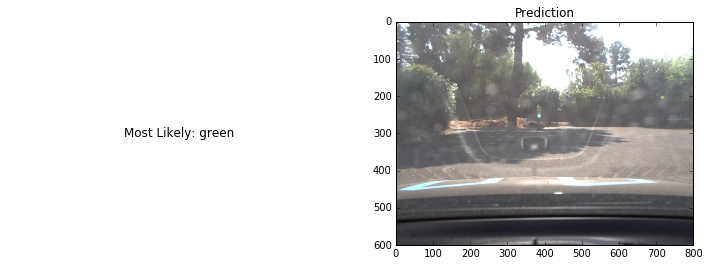

In [50]:
prediction('../../test_images/just_traffic_light_0001.jpg')

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt


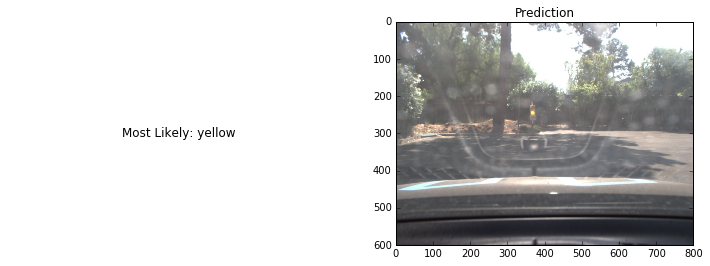

In [51]:
prediction('../../test_images/just_traffic_light_0100.jpg')

INFO:tensorflow:Restoring parameters from ./checkpoints/generator.ckpt


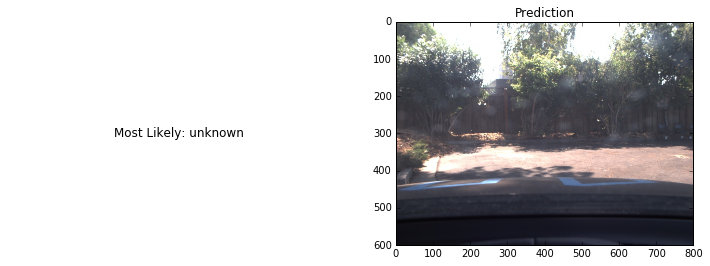

In [52]:
prediction('../../test_images/just_traffic_light_0194.jpg')